# Assignment 4 - Neural Networks

## *Sydney Donati-Leach*
Netid: sd464

*Names of students you worked with on this assignment*: Aarushi Verma, Emma Mavis, Mohammad Anas

Note: this assignment falls under collaboration Mode 2: Individual Assignment – Collaboration Permitted. Please refer to the syllabus for additional information.

Instructions for all assignments can be found [here](https://github.com/kylebradbury/ids705/blob/master/assignments/_Assignment%20Instructions.ipynb), and is also linked to from the [course syllabus](https://kylebradbury.github.io/ids705/index.html).

Total points in the assignment add up to 90; an additional 10 points are allocated to presentation quality.

# Learning objectives
Through completing this assignment you will be able to...
1. Identify key hyperparameters in neural networks and how they can impact model training and fit
2. Build, tune the parameters of, and apply feed-forward neural networks to data
3. Implement and explain each and every part of a standard fully-connected neural network and its operation including feed-forward propagation, backpropagation, and gradient descent.
4. Apply a standard neural network implementation and search the hyperparameter space to select optimized values.
5. Develop a detailed understanding of the math and practical implementation considerations of neural networks, one of the most widely used machine learning tools, so that it can be leveraged for learning about other neural networks of different model architectures.

# 1

## [65 points] Exploring and optimizing neural network hyperparameters
Neural networks have become ubiquitous in the machine learning community, demonstrating exceptional performance over a wide range of supervised learning tasks. The benefits of these techniques come at a price of increased computational complexity and model designs with increased numbers of hyperparameters that need to be correctly set to make these techniques work. It is common that poor hyperparameter choices in neural networks result in significant decreases in model generalization performance. The goal of this exercise is to better understand some of the key hyperparameters you will encounter in practice using neural networks so that you can be better prepared to tune your model for a given application. Through this exercise, you will explore two common approaches to hyperparameter tuning a manual approach where we greedily select the best individual hyperparameter (often people will pick potentially sensible options, try them, and hope it works) as well as a random search of the hyperparameter space which as been shown to be an efficient way to achieve good hyperparameter values. 

To explore this, we'll be using the example data created below throughout this exercise and the various training, validation, test splits. We will select each set of hyperparameters for our greedy/manual approach and the random search using a training/validation split, then retrain on the combined training and validation data before finally evaluating our generalization performance for both our final models on the test data.

In [38]:
# import packages
import sys
import os
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = 'ignore'
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'serif'
from sklearn.model_selection import PredefinedSplit, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, roc_curve
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
from sklearn.neural_network import MLPClassifier
from sklearn.utils.fixes import loguniform
from sklearn import datasets
from sklearn.ensemble import RandomForestClassifier

In [92]:
# Create the data

# Data generation function to create a checkerboard-patterned dataset
def make_data_normal_checkerboard(n, noise=0):
    n_samples = int(n/4)
    shift = 0.5
    c1a = np.random.randn(n_samples,2)*noise + [-shift, shift]
    c1b = np.random.randn(n_samples,2)*noise + [shift, -shift]
    c0a = np.random.randn(n_samples,2)*noise + [shift, shift]
    c0b = np.random.randn(n_samples,2)*noise + [-shift, -shift]
    X = np.concatenate((c1a,c1b,c0a,c0b),axis=0)
    y = np.concatenate((np.ones(2*n_samples), np.zeros(2*n_samples)))
    
    # Set a cutoff to the data and fill in with random uniform data:
    cutoff = 1.25
    indices_to_replace = np.abs(X)>cutoff
    for index,value in enumerate(indices_to_replace.ravel()):
        if value:
            X.flat[index] = np.random.rand()*2.5-1.25
    return (X,y)

# Training datasets
np.random.seed(42)
noise = 0.45
X_train,y_train = make_data_normal_checkerboard(500, noise=noise)
    
# Validation and test data
X_val,y_val = make_data_normal_checkerboard(500, noise=noise)
X_test,y_test = make_data_normal_checkerboard(500, noise=noise)

# For RandomSeachCV, we will need to combine training and validation sets then
#  specify which portion is training and which is validation
# Also, for the final performance evaluation, train on all of the training AND validation data
X_train_plus_val = np.concatenate((X_train, X_val), axis=0)
y_train_plus_val = np.concatenate((y_train, y_val), axis=0)

# Create a predefined train/test split for RandomSearchCV (to be used later)
validation_fold = np.concatenate((-1*np.ones(len(y_train)), np.zeros(len(y_val))))
train_val_split = PredefinedSplit(validation_fold)

To help get you started we should always begin by visualizing our training data, here's some code that does that:

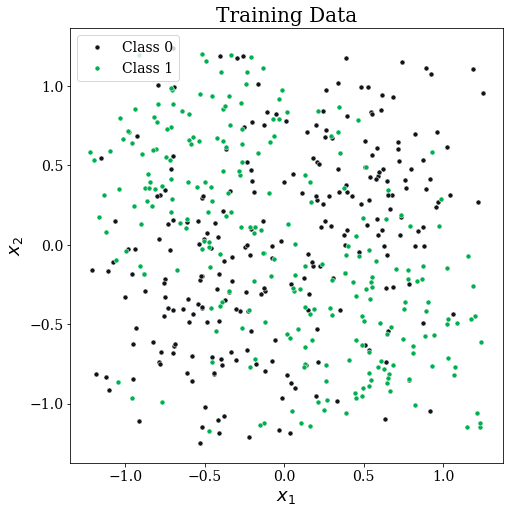

In [40]:


# Code to plot the sample data
def plot_data(ax,X,y,title, limits):
    # Select the colors to use in the plots
    color0 = '#121619' # Dark grey
    color1 = '#00B050' # Green
    color_boundary='#858585'
    
    # Separate samples by class
    samples0 = X[y==0]
    samples1 = X[y==1]

    ax.plot(samples0[:,0],samples0[:,1],
        marker='o',
        markersize=5,
        linestyle="None",
        color=color0,
        markeredgecolor='w',
        markeredgewidth=0.5,
        label='Class 0')
    ax.plot(samples1[:,0],samples1[:,1],
        marker='o',
        markersize=5,
        linestyle="None",
        color=color1,
        markeredgecolor='w',
        markeredgewidth=0.5,
        label='Class 1')
    ax.set_title(title, fontsize=20)
    ax.set_xlabel('$x_1$', fontsize=18)
    ax.set_ylabel('$x_2$', fontsize=18)
    ax.legend(loc='upper left', fontsize=14)
    ax.tick_params(labelsize=14)
    ax.set_aspect('equal')

fig, ax = plt.subplots(figsize=(14,8))
limits = [-1.25, 1.25, -1.25, 1.25]
plot_data(ax, X_train, y_train, 'Training Data', limits)

The hyperparameters we want to explore control the architecture of our model and how our model is fit to our data. These hyperparameters include the (a) learning rate, (b) batch size, and the (c) regularization coefficient, as well as the (d) model architecture hyperparameters (the number of layers and the number of nodes per layer). We'll explore each of these and determine an optimized configuration of the network for this problem through this exercise. For all of the settings we'll explore and just, we'll assume the following default hyperparameters for the model (we'll use scikit learn's [`MLPClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier.score) as our neural network model):
- `learning_rate_init` = 0.03
- `hidden_layer_sizes` = (30,30) (two hidden layers, each with 30 nodes)
- `alpha` = 0 (regularization penalty)
- `solver` = 'sgd' (stochastic gradient descent optimizer)
- `tol` = 1e-5 (this sets the convergence tolerance)
- `early_stopping` = False (this prevents early stopping)
- `activation` = 'relu' (rectified linear unit)
- `n_iter_no_change` = 1000 (this prevents early stopping)
- `batch_size` = 50 (size of the minibatch for stochastic gradient descent)
- `max_iter` = 500 (maximum number of epochs, which is how many times each data point will be used, not the number of gradient steps)

This default setting is our initial guess of what good values may be. Notice there are many model hyperparameters in this list: any of these could potentially be options to search over. We constrain the search to those hyperparameters that are known to have a significant impact on model performance.

**(a) Visualize the impact of different hyperparameter choices on classifier decision boundaries.** Visualize the impact of different hyperparameter settings. Starting with the default settings above make the following changes (only change one hyperparameter at a time). For each hyperparameter value, plot the decision boundary on the training data (you will need to train the model once for each parameter value):
1. Vary the architecture (`hidden_layer_sizes`) by changing the number of nodes per layer while keeping the number of layers constant at 2: (2,2), (5,5), (30,30). Here (X,X) means a 2-layer network with X nodes in each layer.
2. Vary the learning rate: 0.0001, 0.01, 1
3. Vary the regularization: 0, 1, 10
4. Vary the batch size: 5, 50, 500

As you're exploring these settings, visit this website, the [Neural Network Playground](https://playground.tensorflow.org/#activation=relu&batchSize=10&dataset=xor&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=20&networkShape=2,1&seed=0.89022&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false&showTestData_hide=false), which will give you the chance to interactively explore the impact of each of these parameters on a similar dataset to the one we use in this exercise. The tool also allows you to adjust the learning rate, batch size, regularization coefficient, and the architecture and to see the resulting decision boundary and learning curves. You can also visualize the model's hidden node output and its weights, and it allows you to add in transformed features as well. Experiment by adding or removing hidden layers and neurons per layer and vary the hyperparameters.

**(b) Manual (greedy) hyperparameter tuning I: manually optimize hyperparameters that govern the learning process, one hyperparameter at a time.** Now with some insight into which settings may work better than others, let's more fully explore the performance of these different settings in the context of our validation dataset through a manual optimization process. Holding all else constant (with the default settings mentioned above), vary each of the following parameters as specified below. Train your algorithm on the training data, and evaluate the performance of your trained algorithm on the validation dataset. Here, overall accuracy is a reasonable performance metric since the classes are balanced and we don't weight one type of error as more important than the other; therefore, use the `score` method of the `MLPClassifier` for this. Create plots of accuracy vs each parameter you vary (this will result in three plots).
1. Vary learning rate logarithmically from $10^{-5}$ to $10^{0}$ with 20 steps
2. Vary the regularization parameter logarithmically from $10^{-8}$ to $10^2$ with 20 steps
3. Vary the batch size over the following values: $[1,3,5,10,20,50,100,250,500]$

For each of these cases:
- Based on the results, report your optimal choices for each of these hyperparameters and why you selected them.
- Since neural networks can be sensitive to initialization values, you may notice these plots may be a bit noisy. Consider this when selecting the optimal values of the hyperparameters. If the noise seems significant, run the fit and score procedure multiple times and report the average. Rerunning the algorithm will change the initialization and therefore the output (assuming you do not set a random seed for that algorithm).
- Use the chosen hyperparameter values as the new default settings for section (c) and (d).

**(c) Manual (greedy) hyperparameter tuning II: manually optimize hyperparameters that impact the model architecture.** Next, we want to explore the impact of the model architecture on performance and optimize its selection. This means varying two parameters at a time instead of one as above. To do this, evaluate the validation accuracy resulting from training the model using each pair of possible numbers of nodes per layer and number of layers from the lists below. We will assume that for any given configuration the number of nodes in each layer is the same (e.g. (2,2,2), which would be a 3-layer network with 2 hidden node in each layer and (25,25) are valid, but (2,5,3) is not because the number of hidden nodes varies in each layer). Use the manually optimized values for learning rate, regularization, and batch size selected from section (b). 
- Number of nodes per layer: $[1,2,3,4,5,10,15,25,30]$
- Number of layers = $[1,2,3,4]$
Report the accuracy of your model on the validation data. For plotting these results, use heatmaps to plot the data in two dimensions. To make the heatmaps, you can use [this code for creating heatmaps] https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html). Be sure to include the numerical values of accuracy in each grid square as shown in the linked example and label your x, y, and color axes as always. For these numerical values, round them to **2 decimal places** (due to some randomness in the training process, any further precision is not typically meaningful).

- When you select your optimized parameters, be sure to keep in mind that these values may be sensitive to the data and may offer the potential to have high variance for larger models. Therefore, select the model with the highest accuracy but lowest number of total model weights (all else equal, the simpler model is preferred). 
- What do the results show? Which parameters did you select and why?

**(d) Manual (greedy) model selection and retraining.** Based the optimal choice of hyperparameters, train your model with your optimized hyperparameters on all the training data AND the validation data (this is provided as `X_train_plus_val` and `y_train_plus_val`). 
- Apply the trained model to the test data and report the accuracy of your final model on the test data.
- Plot an ROC curve of your performance (plot this with the curve in part (e) on the same set of axes you use for that question).

**(e)** **Automated hyperparameter search through random search**. The manual (greedy) approach (setting one or two parameters at a time holding the rest constant), provides good insights into how the neural network hyperparameters impacts model fitting for this particular training process. However, it is limited in one very problematic way: it depends heavily on a good "default" setting of the hyperparameters. Those were provided for you in this exercise, but are not generally know. Our manual optimization was somewhat greedy because we picked the hyperparameters one at a time rather than looking at different combinations of hyperparameters. Adopting such a pseudo-greedy approach to that manual optimization also limits our ability to more deeply search the hyperparameter space since we don't look at simultaneous changes to multiple parameters. Now we'll use a popular hyperparameter optimization tool to accomplish that: random search.

Random search is an excellent example of a hyperparameter optimization search strategy that has [been shown to be more efficient](https://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a?ref=https://githubhelp.com) (requiring fewer training runs) than another common approach: grid search. Grid search evaluates all possible combinations of hyperparameters from lists of possible hyperparameter settings - a very computationally expensive process. Yet another attractive alternative is [Bayesian Optimization](https://arxiv.org/abs/1807.02811), which is an excellent hyperparameter optimization strategy but we will leave that to the interested reader.

Our particular random search tool will be Scikit-Learn's [`RandomizedSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html#sklearn.model_selection.RandomizedSearchCV). This performs random search employing cross validation for performance evaluation (we will adjust this to ve a train/validation split). 

Using `RandomizedSearchCV`, train on the training data while validating on the validation data (see instructions below on how to setup the train/validation split automatically). This tool will randomly pick combinations of parameter values and test them out, returning the best combination it finds as measured by performance on the validation set. You can use [this example](https://scikit-learn.org/stable/auto_examples/model_selection/plot_randomized_search.html#sphx-glr-auto-examples-model-selection-plot-randomized-search-py) as a template for how to do this.
- To make this comparable to the training/validation setup used for the greedy optimization, we need to setup a training and validation split rather than use cross validation. To do this for `RandomSearchCV` we input the COMBINED training and validation dataset (`X_train_plus_val`, and `y_train_plus_val`) and we set the `cv` parameter to be the `train_val_split` variable we provided along with the dataset. This will setup the algorithm to make its assessments training just on the training data and evaluation on the validation data. Once `RandomSearchCV` completes its search, it will fit the model one more time to the combined training and validation data using the optimized parameters as we would want it to.
- Set the number of iterations to at least 200 (you'll look at 200 random pairings of possible hyperparameters). You can go as high as you want, but it will take longer the larger the value.
- If you run this on Colab or any system with multiple cores, set the parameter `n_jobs` to -1 to use all available cores for more efficient training through parallelization
- You'll need to set the range or distribution of the parameters you want to sample from. Search over the same ranges as in previous problems. To tell the algorithm the ranges to search, use lists of values for candidate batch_size, since those need to be integers rather than a range; the `loguniform` `scipy` function for setting the range of the learning rate and regularization parameter, and a list of tuples for the `hidden_layer_sizes` parameter, as you used in the greedy optimization.
- Once the model is fit, use the `best_params_` property of the fit classifier attribute to extract the optimized values of the hyperparameters and report those and compare them to what was selected through the manual, greedy optimization.

For the final generalization performance assessment:
- State the accuracy of the optimized models on the test dataset
- Plot the ROC curve corresponding to your best model on the test dataset through greedy hyperparameter section vs the model identified through random search (these curves should be on the same set of axes for comparison). In the legend of the plot, report the AUC for each curve
- Plot the final decision boundary for the greedy and random search-based classifiers along with the test dataset to demonstrate the shape of the final boundary
- How did the generalization performance compare between the hyperparameters selected through the manual (greedy) search and the random search?

**(a) Visualize the impact of different hyperparameter choices on classifier decision boundaries.** Visualize the impact of different hyperparameter settings. Starting with the default settings above make the following changes (only change one hyperparameter at a time). For each hyperparameter value, plot the decision boundary on the training data (you will need to train the model once for each parameter value):

Default settings:
- `learning_rate_init` = 0.03
- `hidden_layer_sizes` = (30,30) (two hidden layers, each with 30 nodes)
- `alpha` = 0 (regularization penalty)
- `solver` = 'sgd' (stochastic gradient descent optimizer)
- `tol` = 1e-5 (this sets the convergence tolerance)
- `early_stopping` = False (this prevents early stopping)
- `activation` = 'relu' (rectified linear unit)
- `n_iter_no_change` = 1000 (this prevents early stopping)
- `batch_size` = 50 (size of the minibatch for stochastic gradient descent)
- `max_iter` = 500 (maximum number of epochs, which is how many times each data point will be used, not the number of gradient steps)

1. Vary the architecture (`hidden_layer_sizes`) by changing the number of nodes per layer while keeping the number of layers constant at 2: (2,2), (5,5), (30,30). Here (X,X) means a 2-layer network with X nodes in each layer.
2. Vary the learning rate: 0.0001, 0.01, 1
3. Vary the regularization: 0, 1, 10
4. Vary the batch size: 5, 50, 500

**ANSWER**

In [41]:
# create arrays for each of the hyperparameters
hidden_layers = [(30,30),(5,5),(2,2)]
learning_rates = [0.0001,0.01,1]
regularizations = [0,1,10]
batch_sizes = [5,50,500]

In [42]:
# create empty list to store all the models
models = []

# fit models to each hidden layer size
for hl in hidden_layers:
    model = MLPClassifier(learning_rate_init = 0.03,
        hidden_layer_sizes = hl,
        alpha = 0,
        solver = 'sgd',
        tol = 1e-5,
        early_stopping = False,
        activation = 'relu',
        n_iter_no_change = 1000,
        batch_size = 50,
        max_iter = 500).fit(X_train, y_train)
    models.append(model)

# fit models to each learning rate
for lr in learning_rates:
    model = MLPClassifier(learning_rate_init = lr,
        hidden_layer_sizes = (30,30),
        alpha = 0,
        solver = 'sgd',
        tol = 1e-5,
        early_stopping = False,
        activation = 'relu',
        n_iter_no_change = 1000,
        batch_size = 50,
        max_iter = 500).fit(X_train, y_train)
    models.append(model)

# fit models to each regularization penalty
for reg in regularizations:
    model = MLPClassifier(learning_rate_init = 0.03,
        hidden_layer_sizes = (30,30),
        alpha = reg,
        solver = 'sgd',
        tol = 1e-5,
        early_stopping = False,
        activation = 'relu',
        n_iter_no_change = 1000,
        batch_size = 50,
        max_iter = 500).fit(X_train, y_train)
    models.append(model)

# fit models to each batch size
for batch in batch_sizes:
    model = MLPClassifier(learning_rate_init = 0.03,
        hidden_layer_sizes = (30,30),
        alpha = 0,
        solver = 'sgd',
        tol = 1e-5,
        early_stopping = False,
        activation = 'relu',
        n_iter_no_change = 1000,
        batch_size = batch,
        max_iter = 500).fit(X_train, y_train)
    models.append(model)

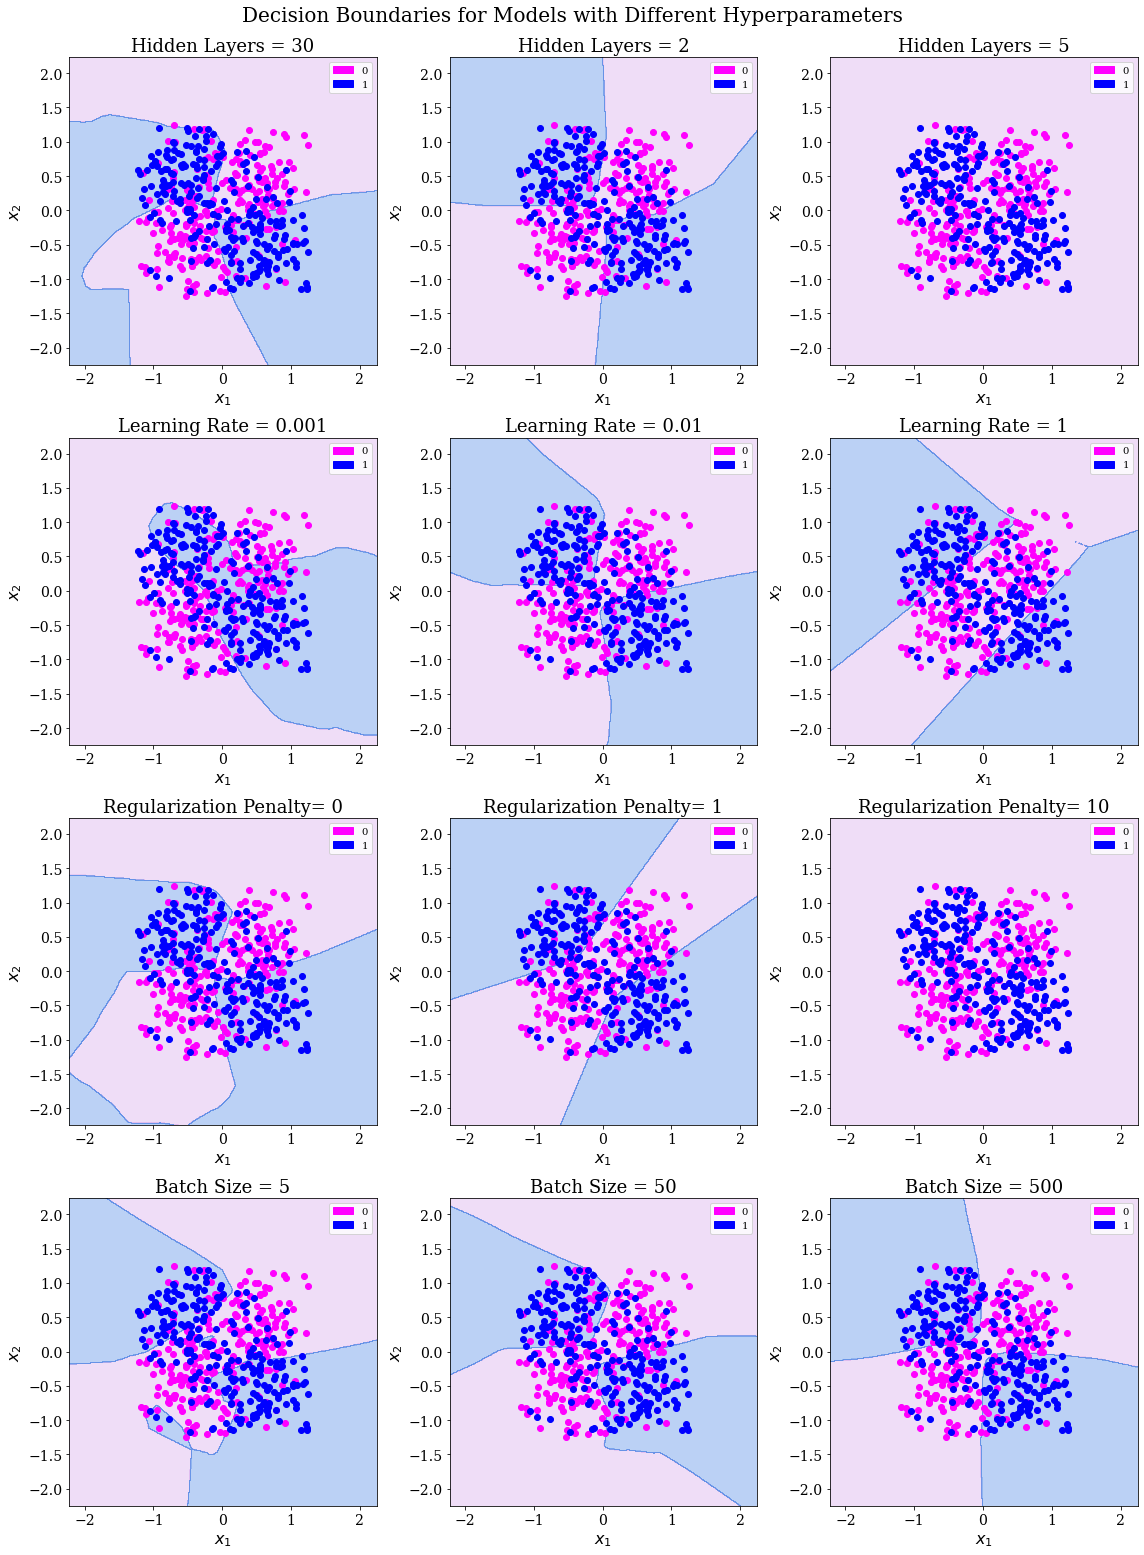

In [43]:
# plot the decision boundaries for each model
h=0.01

fig, ax = plt.subplots(4,3,figsize=(16,22))
fig.suptitle("Decision Boundaries for Models with Different Hyperparameters\n", fontsize=20)
titles = ['Hidden Layers = 30', 'Hidden Layers = 2', 'Hidden Layers = 5',
    'Learning Rate = 0.001', 'Learning Rate = 0.01', 'Learning Rate = 1',
    'Regularization Penalty= 0', 'Regularization Penalty= 1', 'Regularization Penalty= 10',
    'Batch Size = 5', 'Batch Size = 50', 'Batch Size = 500']

plot_col=0
plot_row=0
i = 0

# iterate over models
for model in models:
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min_0, x_max_0 = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    x_min_1, x_max_1 = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min_0, x_max_0, h),
                            np.arange(x_min_1, x_max_1, h))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # creating the background colors
    cmap_light = ListedColormap(['#D8ABEB','#558CE6'])
    ax[plot_row,plot_col].contourf(xx, yy, Z, cmap=cmap_light, alpha=0.4)

    # creating the points
    ax[plot_row,plot_col].scatter(
        X_train[y_train==0][:,0],
        X_train[y_train==0][:,1],
        color="magenta", 
        label="Class 0"
    )
    ax[plot_row,plot_col].scatter(
        X_train[y_train==1][:,0],
        X_train[y_train==1][:,1],
        color="blue",
        label="Class 1"
    )

    #creating the legends
    label_pink = mpatches.Patch(color= "magenta", label="0", hatch="o")
    label_blue = mpatches.Patch(color="blue", label="1", hatch="o")
    ax[plot_row,plot_col].legend(handles=[label_pink,label_blue],loc='best')


    # creating the labels and titles
    ax[plot_row,plot_col].set_title(titles[i], fontsize=18)
    ax[plot_row,plot_col].set_xlabel("$x_1$", fontsize=16)
    ax[plot_row,plot_col].set_ylabel("$x_2$", fontsize=16)
    ax[plot_row,plot_col].tick_params(labelsize=14)

    # increment to the next model and column
    if plot_col==2:
        plot_col=0
        plot_row+=1
    else:
        plot_col+=1
    i+= 1

fig.tight_layout()
plt.show()

**(b) Manual (greedy) hyperparameter tuning I: manually optimize hyperparameters that govern the learning process, one hyperparameter at a time.** Now with some insight into which settings may work better than others, let's more fully explore the performance of these different settings in the context of our validation dataset through a manual optimization process. Holding all else constant (with the default settings mentioned above), vary each of the following parameters as specified below. Train your algorithm on the training data, and evaluate the performance of your trained algorithm on the validation dataset. Here, overall accuracy is a reasonable performance metric since the classes are balanced and we don't weight one type of error as more important than the other; therefore, use the `score` method of the `MLPClassifier` for this. Create plots of accuracy vs each parameter you vary (this will result in three plots).
1. Vary learning rate logarithmically from $10^{-5}$ to $10^{0}$ with 20 steps
2. Vary the regularization parameter logarithmically from $10^{-8}$ to $10^2$ with 20 steps
3. Vary the batch size over the following values: $[1,3,5,10,20,50,100,250,500]$

For each of these cases:
- Based on the results, report your optimal choices for each of these hyperparameters and why you selected them.
- Since neural networks can be sensitive to initialization values, you may notice these plots may be a bit noisy. Consider this when selecting the optimal values of the hyperparameters. If the noise seems significant, run the fit and score procedure multiple times and report the average. Rerunning the algorithm will change the initialization and therefore the output (assuming you do not set a random seed for that algorithm).
- Use the chosen hyperparameter values as the new default settings for section (c) and (d).

**ANSWER**

In [44]:
# create lists of hyperparameters for each model
learning_rates = np.logspace(-5,0,20)
regularizations = np.logspace(-8,2,20)
batch_sizes = [1,3,5,10,20,50,100,250,500]

lr_scores = []
reg_scores = []
batch_scores = []

# fit models to each learning rate
for lr in learning_rates:
    model = MLPClassifier(learning_rate_init = lr,
        hidden_layer_sizes = (30,30),
        alpha = 0,
        solver = 'sgd',
        tol = 1e-5,
        early_stopping = False,
        activation = 'relu',
        n_iter_no_change = 1000,
        batch_size = 50,
        max_iter = 500).fit(X_train, y_train)
    lr_scores.append(model.score(X_val, y_val))

# fit models to each regularization penalty
for reg in regularizations:
    model = MLPClassifier(learning_rate_init = 0.03,
        hidden_layer_sizes = (30,30),
        alpha = reg,
        solver = 'sgd',
        tol = 1e-5,
        early_stopping = False,
        activation = 'relu',
        n_iter_no_change = 1000,
        batch_size = 50,
        max_iter = 500).fit(X_train, y_train)
    reg_scores.append(model.score(X_val, y_val))

# fit models to each batch size
for batch in batch_sizes:
    model = MLPClassifier(learning_rate_init = 0.03,
        hidden_layer_sizes = (30,30),
        alpha = 0,
        solver = 'sgd',
        tol = 1e-5,
        early_stopping = False,
        activation = 'relu',
        n_iter_no_change = 1000,
        batch_size = batch,
        max_iter = 500).fit(X_train, y_train)
    batch_scores.append(model.score(X_val, y_val))

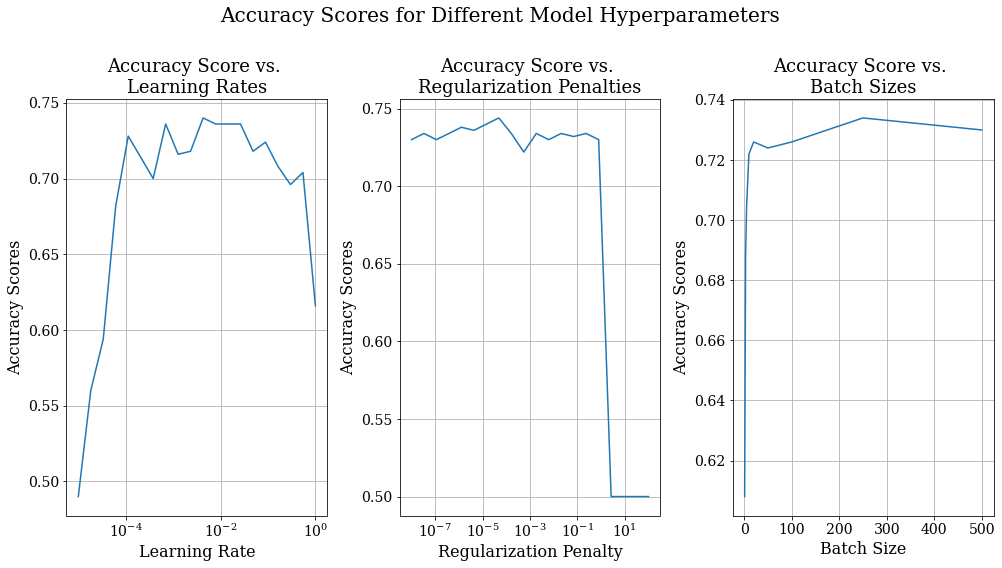

In [45]:
# plotting the results
fig, ax = plt.subplots(1,3,figsize=(14,8))
fig.suptitle("Accuracy Scores for Different Model Hyperparameters\n", fontsize=20)

ax[0].plot(learning_rates,lr_scores)
ax[0].set_xlabel("Learning Rate", fontsize=16)
ax[0].set_ylabel("Accuracy Scores", fontsize=16)
ax[0].set_title("Accuracy Score vs. \nLearning Rates", fontsize=18)
ax[0].set_xscale('log')
ax[0].tick_params(labelsize=14)
ax[0].grid()

ax[1].plot(regularizations,reg_scores)
ax[1].set_xlabel("Regularization Penalty", fontsize=16)
ax[1].set_ylabel("Accuracy Scores", fontsize=16)
ax[1].set_title("Accuracy Score vs. \nRegularization Penalties", fontsize=18)
ax[1].set_xscale('log')
ax[1].tick_params(labelsize=14)
ax[1].grid()

ax[2].plot(batch_sizes,batch_scores)
ax[2].set_xlabel("Batch Size", fontsize=16)
ax[2].set_ylabel("Accuracy Scores", fontsize=16)
ax[2].set_title("Accuracy Score vs. \nBatch Sizes", fontsize=18)
ax[2].tick_params(labelsize=14)
ax[2].grid()

plt.tight_layout()
plt.show()

Below are my optimal choices for each of these hyperparameters:
- Learning Rate: $10^{-2}$
- Regularization Penalty: $10^{-4}$
- Batch Size: 250

I chose these hyperparameters because the accuracy scores reach their highest points on the y-axis around each of these respective points on the x-axis.

**(c) Manual (greedy) hyperparameter tuning II: manually optimize hyperparameters that impact the model architecture.** Next, we want to explore the impact of the model architecture on performance and optimize its selection. This means varying two parameters at a time instead of one as above. To do this, evaluate the validation accuracy resulting from training the model using each pair of possible numbers of nodes per layer and number of layers from the lists below. We will assume that for any given configuration the number of nodes in each layer is the same (e.g. (2,2,2), which would be a 3-layer network with 2 hidden node in each layer and (25,25) are valid, but (2,5,3) is not because the number of hidden nodes varies in each layer). Use the manually optimized values for learning rate, regularization, and batch size selected from section (b). 
- Number of nodes per layer: $[1,2,3,4,5,10,15,25,30]$
- Number of layers = $[1,2,3,4]$
- Report the accuracy of your model on the validation data. For plotting these results, use heatmaps to plot the data in two dimensions. To make the heatmaps, you can use [this code for creating heatmaps] https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html). Be sure to include the numerical values of accuracy in each grid square as shown in the linked example and label your x, y, and color axes as always. For these numerical values, round them to **2 decimal places** (due to some randomness in the training process, any further precision is not typically meaningful).

- When you select your optimized parameters, be sure to keep in mind that these values may be sensitive to the data and may offer the potential to have high variance for larger models. Therefore, select the model with the highest accuracy but lowest number of total model weights (all else equal, the simpler model is preferred). 
- What do the results show? Which parameters did you select and why?

**ANSWER**

In [46]:
# create arrays for each of the layers
layers_1 = np.array([[1],[2],[3],[4],[5],[10],[15],[25],[30]])
layers_2 = np.array([[1,1],[2,2],[3,3],[4,4],[5,5],[10,10],[15,15]\
    ,[25,25],[30,30]])
layers_3 = np.array([[1,1,1],[2,2,2],[3,3,3],[4,4,4],[5,5,5],\
    [10,10,10],[15,15,15],[25,25,25],[30,30,30]])
layers_4 = np.array([[1,1,1,1],[2,2,2,2],[3,3,3,3],[4,4,4,4],[5,5,5,5]\
    ,[10,10,10,10],[15,15,15,15],[25,25,25,25],[30,30,30,30]])

In [47]:
# fit models to each number of hidden layers

# set optimized hyperparameters
lr = 10**-2
reg = 10**-4
batch = 250

layer_1_scores = []
# fit models with 1 layer
for layer in layers_1:
    model = MLPClassifier(learning_rate_init = lr,
        hidden_layer_sizes = layer,
        alpha = reg,
        solver = 'sgd',
        tol = 1e-5,
        early_stopping = False,
        activation = 'relu',
        n_iter_no_change = 1000,
        batch_size = batch,
        max_iter = 500,
        random_state=10).fit(X_train, y_train)
    layer_1_scores.append(round(model.score(X_val, y_val),2))

layer_2_scores = []
# fit models with 2 layers
for layer in layers_2:
    model = MLPClassifier(learning_rate_init = lr,
        hidden_layer_sizes = layer,
        alpha = reg,
        solver = 'sgd',
        tol = 1e-5,
        early_stopping = False,
        activation = 'relu',
        n_iter_no_change = 1000,
        batch_size = batch,
        max_iter = 500,
        random_state=20).fit(X_train, y_train)
    layer_2_scores.append(round(model.score(X_val, y_val),2))

layer_3_scores = []
# fit models with 3 layers
for layer in layers_3:
    model = MLPClassifier(learning_rate_init = lr,
        hidden_layer_sizes = layer,
        alpha = reg,
        solver = 'sgd',
        tol = 1e-5,
        early_stopping = False,
        activation = 'relu',
        n_iter_no_change = 1000,
        batch_size = batch,
        max_iter = 500,
        random_state=30).fit(X_train, y_train)
    layer_3_scores.append(round(model.score(X_val, y_val),2))

layer_4_scores = []
# fit models with 3 layers
for layer in layers_4:
    model = MLPClassifier(learning_rate_init = lr,
        hidden_layer_sizes = layer,
        alpha = reg,
        solver = 'sgd',
        tol = 1e-5,
        early_stopping = False,
        activation = 'relu',
        n_iter_no_change = 1000,
        batch_size = batch,
        max_iter = 500,
        random_state=40).fit(X_train, y_train)
    layer_4_scores.append(round(model.score(X_val, y_val),2))

In [48]:
# create arrays for the heatmap
nodes = [1,2,3,4,5,10,15,25,30]
layers = [4,3,2,1]
scores = np.array((layer_4_scores,layer_3_scores, layer_2_scores, layer_1_scores))

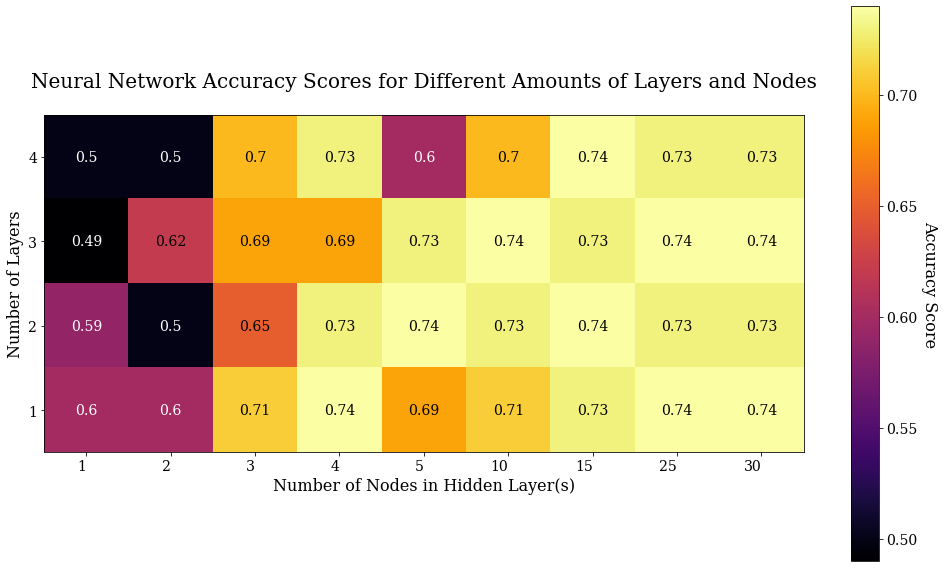

In [49]:
# plot the heatmap
fig, ax = plt.subplots(figsize=(14,8))
im = ax.imshow(scores, cmap="inferno")


# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(nodes)))
ax.set_yticks(np.arange(len(layers)))
ax.set_xticklabels(nodes)
ax.set_yticklabels(layers)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
# Change the text's color depending on the data.
textcolors=("white","black")
for i in range(len(layers)):
    for j in range(len(nodes)):
        text = ax.text(j, i, scores[i, j],
                       ha="center", va="center", 
                       color=textcolors[int(im.norm(scores[i, j]) > .5)],
                       fontsize=14)

ax.set_title("Neural Network Accuracy Scores for Different Amounts"
" of Layers and Nodes\n", fontsize=20)
ax.set_xlabel("Number of Nodes in Hidden Layer(s)", fontsize=16)
ax.set_ylabel("Number of Layers", fontsize=16)
ax.tick_params(labelsize=14)

# Add color bar
cbarlabel = "Accuracy Score"
cbar = ax.figure.colorbar(im, ax=ax)
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(14)
cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom", fontsize=16)


fig.tight_layout()
plt.show()

The results of the heatmap show that as the number of nodes in the hidden layer(s) increases, the accuracy score increases.  The highest accuracy score in the heatmap is 74%. Since a simpler model is preferred over a more complex one, we would want to chose the model with __1 hidden layer and 4 nodes__ which also has an accuracy score of 74%.

**(d) Manual (greedy) model selection and retraining.** Based the optimal choice of hyperparameters, train your model with your optimized hyperparameters on all the training data AND the validation data (this is provided as `X_train_plus_val` and `y_train_plus_val`). 
- Apply the trained model to the test data and report the accuracy of your final model on the test data.
- Plot an ROC curve of your performance (plot this with the curve in part (e) on the same set of axes you use for that question).

**ANSWER**

In [139]:
# fit model with greedy hyperparameters
layer = 4

greedy_model = MLPClassifier(learning_rate_init = lr,
        hidden_layer_sizes = layer,
        alpha = reg,
        solver = 'sgd',
        tol = 1e-5,
        early_stopping = False,
        activation = 'relu',
        n_iter_no_change = 1000,
        batch_size = batch,
        max_iter = 500,
        random_state=123).fit(X_train_plus_val, y_train_plus_val)
accuracy = (greedy_model.score(X_test, y_test))*100

print("The accuracy of the greedy search model is {:.1f}%".format(accuracy))

The accuracy of the greedy search model is 73.6%


**(e)** **Automated hyperparameter search through random search**.

Using `RandomizedSearchCV`, train on the training data while validating on the validation data (see instructions below on how to setup the train/validation split automatically). This tool will randomly pick combinations of parameter values and test them out, returning the best combination it finds as measured by performance on the validation set. You can use [this example](https://scikit-learn.org/stable/auto_examples/model_selection/plot_randomized_search.html#sphx-glr-auto-examples-model-selection-plot-randomized-search-py) as a template for how to do this.
- To make this comparable to the training/validation setup used for the greedy optimization, we need to setup a training and validation split rather than use cross validation. To do this for `RandomSearchCV` we input the COMBINED training and validation dataset (`X_train_plus_val`, and `y_train_plus_val`) and we set the `cv` parameter to be the `train_val_split` variable we provided along with the dataset. This will setup the algorithm to make its assessments training just on the training data and evaluation on the validation data. Once `RandomSearchCV` completes its search, it will fit the model one more time to the combined training and validation data using the optimized parameters as we would want it to.
- Set the number of iterations to at least 200 (you'll look at 200 random pairings of possible hyperparameters). You can go as high as you want, but it will take longer the larger the value.
- If you run this on Colab or any system with multiple cores, set the parameter `n_jobs` to -1 to use all available cores for more efficient training through parallelization
- You'll need to set the range or distribution of the parameters you want to sample from. Search over the same ranges as in previous problems. To tell the algorithm the ranges to search, use lists of values for candidate batch_size, since those need to be integers rather than a range; the `loguniform` `scipy` function for setting the range of the learning rate and regularization parameter, and a list of tuples for the `hidden_layer_sizes` parameter, as you used in the greedy optimization.
- Once the model is fit, use the `best_params_` property of the fit classifier attribute to extract the optimized values of the hyperparameters and report those and compare them to what was selected through the manual, greedy optimization.

**ANSWER**

In [113]:
# specify parameters and distributions to sample from
nodelayerlist = [tuple([n]) * l for n in nodes for l in layers]
param_dist = {
    "hidden_layer_sizes": nodelayerlist,
    "learning_rate_init": loguniform(10e-5, 10e0),
    "alpha": loguniform(10e-8, 10e2),
    "batch_size": [1,3,5,10,20,50,100,250,500]
}

# build a model
clf = MLPClassifier(solver='sgd', tol=1e-5, early_stopping=False,
                    activation='relu')


# run randomized search
n_iter_search = 200
random_search = RandomizedSearchCV(
    clf, param_distributions=param_dist, n_iter=n_iter_search,
    n_jobs=-1, cv=train_val_split, random_state=123
)

random_search.fit(X_train_plus_val, y_train_plus_val)

RandomizedSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
                   estimator=MLPClassifier(solver='sgd', tol=1e-05), n_iter=200,
                   n_jobs=-1,
                   param_distributions={'alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f505903ce50>,
                                        'batch_size': [1, 3, 5, 10, 20, 50, 100,
                                                       250, 500],
                                        'hidden_layer_sizes': [(1, 1, 1, 1),
                                                               (1, 1, 1),
                                                               (1, 1), (1,),
                                                               (2, 2, 2, 2),
                                                               (2, 2, 2),
                                                               (2, 2), (2,),
                                                               (3, 3, 3, 3),
         

In [120]:
# random search results
best_model = random_search.best_params_
print("The random search hyperparameters are: ")
print("Hidden Layers: ", best_model['hidden_layer_sizes'])
print("Learning Rate: ", best_model['learning_rate_init'])
print("Regularization: ", best_model['alpha'])
print("Batch Size: ", best_model['batch_size'])

The random search hyperparameters are: 
Hidden Layers:  (5,)
Learning Rate:  0.020395943857380645
Regularization:  1.4861696179502018e-06
Batch Size:  50


For the final generalization performance assessment:
- State the accuracy of the optimized models on the test dataset

In [115]:
# fit model with optimal hyperparameters
random_search_model = MLPClassifier(learning_rate_init = best_model['learning_rate_init'],
        hidden_layer_sizes = best_model['hidden_layer_sizes'],
        alpha = best_model['alpha'],
        solver = 'sgd',
        tol = 1e-5,
        early_stopping = False,
        activation = 'relu',
        n_iter_no_change = 1000,
        batch_size = best_model['batch_size'],
        max_iter = 500,
        random_state=123).fit(X_train_plus_val, y_train_plus_val)
accuracy = (random_search_model.score(X_test, y_test))*100

print("The accuracy of the random search model is {:.1f}%".format(accuracy))

The accuracy of the random search model is 72.4%


Plot the ROC curve corresponding to your best model on the test dataset through greedy hyperparameter section vs the model identified through random search (these curves should be on the same set of axes for comparison). In the legend of the plot, report the AUC for each curve.

<function matplotlib.pyplot.show(close=None, block=None)>

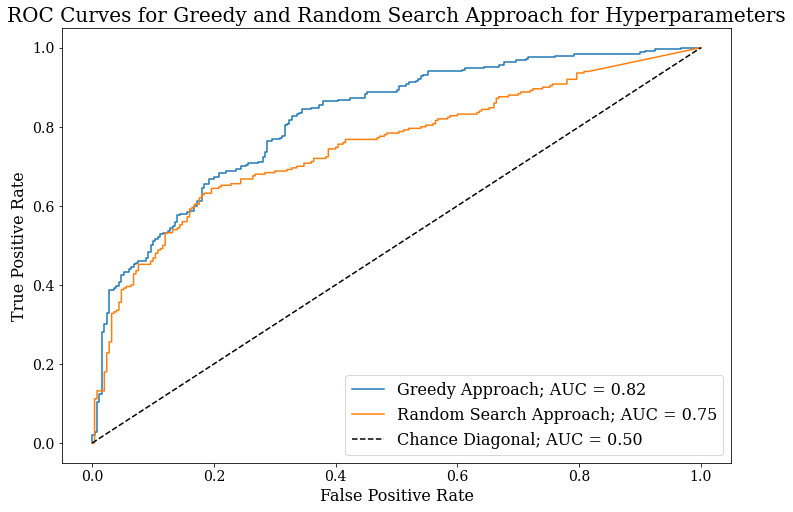

In [118]:
# predict probabilities
greedy_probs = (greedy_model.predict_proba(X_test)[:,1])
random_probs = (np.array(random_search_model.predict_proba(X_test)[:,1]))
# roc curves
greedy_fpr,greedy_tpr,threshold = roc_curve(y_test, greedy_probs)
random_fpr,random_tpr,threshold = roc_curve(y_test, random_probs)
# auc's
greedy_roc_auc = auc(greedy_fpr, greedy_tpr)
random_roc_auc = auc(random_fpr, random_tpr)
# plot the roc curves
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(greedy_fpr,greedy_tpr, label="Greedy Approach; AUC = %0.2f" % greedy_roc_auc)
plt.plot(random_fpr,random_tpr, label="Random Search Approach; AUC = %0.2f" %  random_roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label="Chance Diagonal; AUC = %0.2f" % 0.5)
plt.xlabel("False Positive Rate", fontsize=16)
plt.ylabel("True Positive Rate", fontsize=16)
plt.tick_params(labelsize=14)
plt.title("ROC Curves for Greedy and Random Search Approach for Hyperparameters", fontsize=20)
plt.legend(loc='lower right', fontsize=16)
plt.show

Plot the final decision boundary for the greedy and random search-based classifiers along with the test dataset to demonstrate the shape of the final boundary.

In [123]:
models = [greedy_model, random_search_model]

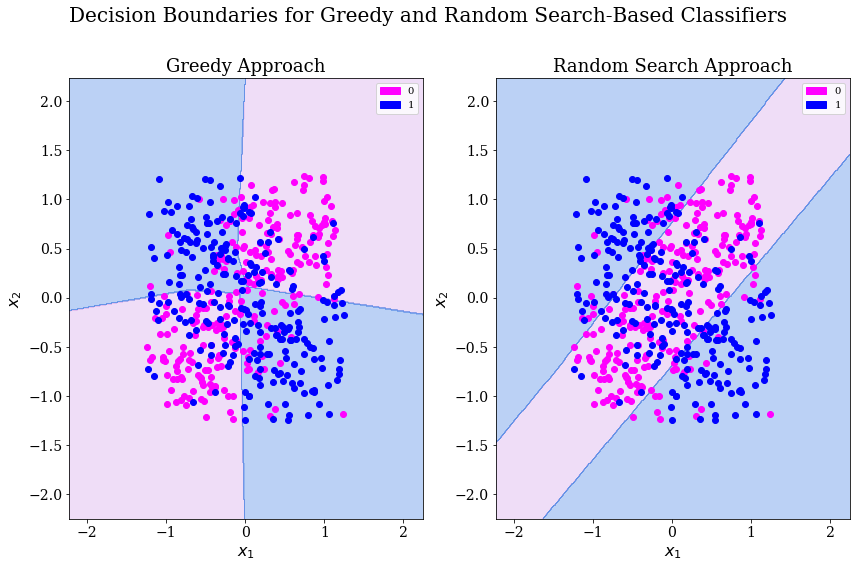

In [136]:
# plot the decision boundaries for each model
h=0.01

fig, ax = plt.subplots(1,2,figsize=(12,8))
fig.suptitle("Decision Boundaries for Greedy and Random Search-Based Classifiers\n", fontsize=20)
titles = ["Greedy Approach", "Random Search Approach"]

plot_col=0
i = 0

# iterate over models
for model in models:
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min_0, x_max_0 = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    x_min_1, x_max_1 = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min_0, x_max_0, h),
                            np.arange(x_min_1, x_max_1, h))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # creating the background colors
    cmap_light = ListedColormap(['#D8ABEB','#558CE6'])
    ax[plot_col].contourf(xx, yy, Z, cmap=cmap_light, alpha=0.4)

    # creating the test points
    ax[plot_col].scatter(
        X_test[y_test==0][:,0],
        X_test[y_test==0][:,1],
        color="magenta", 
        label="Class 0"
    )
    ax[plot_col].scatter(
        X_test[y_test==1][:,0],
        X_test[y_test==1][:,1],
        color="blue",
        label="Class 1"
    )

    #creating the legends
    label_pink = mpatches.Patch(color= "magenta", label="0", hatch="o")
    label_blue = mpatches.Patch(color="blue", label="1", hatch="o")
    ax[plot_col].legend(handles=[label_pink,label_blue],loc='best')


    # creating the labels and titles
    ax[plot_col].set_title(titles[i], fontsize=18)
    ax[plot_col].set_xlabel("$x_1$", fontsize=16)
    ax[plot_col].set_ylabel("$x_2$", fontsize=16)
    ax[plot_col].tick_params(labelsize=14)

    # increment to the next model and column
    plot_col+=1
    i+= 1

fig.tight_layout()
plt.show()

How did the generalization performance compare between the hyperparameters selected through the manual (greedy) search and the random search?

- The generalization of the greedy search performs better than the random search. The accuracy score for the greedy search is larger than the random search by a little more than 1%, the greedy AUC is larger than the random search AUC by roughly 7%, and the decision boundaries for the greedy search clearly align better than the random search decision boundaries with our checkerboard test data.

# 2

## [25 points] Build and test your own Neural Network for classification

There is no better way to understand how one of the core techniques of modern machine learning works than to build a simple version of it yourself. In this exercise you will construct and apply your own neural network classifier. You may use numpy if you wish but no other libraries.

**(a) [OPTIONAL - 10 BONUS POINTS]** Create a neural network class that follows the `scikit-learn` classifier convention by implementing `fit`, `predict`, and `predict_proba` methods. Your `fit` method should run backpropagation on your training data using stochastic gradient descent. Assume the activation function is a sigmoid. Choose your model architecture to have two input nodes, two hidden layers with five nodes each, and one output node.

To guide you in the right direction with this problem, please find a skeleton of a neural network class below. You absolutely MAY use additional methods beyond those suggested in this template, but the methods listed below are the minimum required to implement the model cleanly.

**Strategies for debugging**. One of the greatest challenges of this implementations is that there are many parts and a bug could be present in any of them. Here are some recommended tips:
- *Development environment*. Consider using an Integrated Development Environment (IDE). I strongly recommend the use of VS Code and the Python debugging tools in that development environment.
- *Unit tests*. You are strongly encouraged to create unit tests for most modules. Without doing this will make your code extremely difficult to bug. You can create simple examples to feed through the network to validate it is correctly computing activations and node values. Also, if you manually set the weights of the model, you can even calculate backpropagation by hand for some simple examples (admittedly, that unit test would be challenging and is optional, but a unit test is possible). 
- *Compare against a similar architecture*. You can also verify the performance of your overall neural network by comparing it against the `scikit-learn` implementation and using the same architecture and parameters as your model (your model outputs will certainly not be identical, but they should be somewhat similar for similar parameter settings).

**NOTE: if you choose not to build your own neural network, then use the `scikit-learn` implementation instead in the questions below; where it asks to compare to `scikit-learn`, compare against a random forest classifier instead**

**(b)** Apply your neural network. 
- Create a training and validation dataset using `sklearn.datasets.make_moons(N, noise=0.20)`, where $N_{train} = 500$ and $N_{test} = 100$. 
- Train and test your model on this dataset plotting your learning curves (training and validation error for each epoch of stochastic gradient descent, where an epoch represents having trained on each of the training samples one time).
- Tune the learning rate and number of training epochs for your model to improve performance as needed. 
- In two subplots, plot the training data on one subplot, and the validation data on the other subplot. On each plot, also plot the decision boundary from your neural network trained on the training data. 
- Report your performance on the test data with an ROC curve and compare against the `scikit-learn` `MLPClassifier` trained with the same parameters.

**ANSWER**

Create a training and validation dataset using `sklearn.datasets.make_moons(N, noise=0.20)`, where $N_{train} = 500$ and $N_{test} = 100$

In [25]:
# Create a synthetic dataset (with both features and targets)
raw_data = datasets.make_moons(n_samples=600, noise=0.2)
X, y = raw_data
# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/6, random_state=42)
# split into train and validation
X_train_2, X_val, y_train_2, y_val = train_test_split(X_train, y_train, test_size=1/5, random_state=42)

Train and test your model on this dataset plotting your learning curves (training and validation error for each epoch of stochastic gradient descent, where an epoch represents having trained on each of the training samples one time).

In [3]:
# create a function to calculate the error/loss of a model
def cross_entropy(y, pred):
    n = len(y)
    # Calculating loss
    loss = sum((y*np.log(pred))) + sum(((1-y)*np.log(1-pred)))
    loss = -loss/n
    return loss

In [4]:
# learning rate 0.001
mlp = MLPClassifier(max_iter=300 , learning_rate_init= 0.001, 
    hidden_layer_sizes=(5,5), solver='sgd', activation='logistic',  
    batch_size=1, tol=1e-10, early_stopping=False, n_iter_no_change = 300,
    random_state=123, warm_start=True)

N_TRAIN_SAMPLES = X_train_2.shape[0]
N_EPOCHS = 2000
N_BATCH = 100
N_CLASSES = np.unique(y_train_2)

# empty lists to store training and validation loss
train_loss = []
val_loss = []
lr_score = []
epoch = 0
# iterate over epochs
while epoch < N_EPOCHS:
    # shuffle the training data
    random_perm = np.random.permutation(X_train_2.shape[0])
    mini_batch_index = 0
    while True:
        # iterate through the mini-batches
        indices = random_perm[mini_batch_index:mini_batch_index + N_BATCH]
        mlp.partial_fit(X_train_2[indices], y_train_2[indices], classes=N_CLASSES)
        mini_batch_index += N_BATCH
        # check if we are done with all the mini-batches
        if mini_batch_index >= N_TRAIN_SAMPLES:
            break
    # get training and validation predictions
    X_train_pred = mlp.predict_proba(X_train_2)
    X_val_pred = mlp.predict_proba(X_val)
    # calculate training and validation loss
    train_loss.append(cross_entropy(y_train_2, X_train_pred[:,1]))
    val_loss.append(cross_entropy(y_val, X_val_pred[:,1]))
    lr_score.append(mlp.score(X_val, y_val))

    epoch += 1

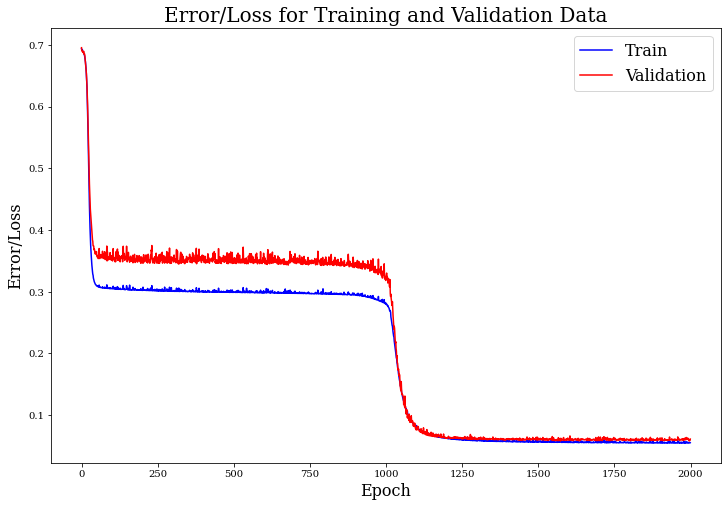

In [5]:
# plot the loss
plt.figure(figsize=(12,8))
plt.title('Error/Loss for Training and Validation Data', fontsize=20)
plt.plot(train_loss, label='Train', color='blue')
plt.plot(val_loss, label='Validation', color='red')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Error/Loss', fontsize=16)
plt.legend(loc='best', fontsize=16)
plt.show()

Tune the learning rate and number of training epochs for your model to improve performance as needed.

In [6]:
# learning rate 0.01
mlp = MLPClassifier(max_iter=300 , learning_rate_init= 0.01, 
    hidden_layer_sizes=(5,5), solver='sgd', activation='logistic',  
    batch_size=1, tol=1e-10, early_stopping=False, n_iter_no_change = 300,
    random_state=123, warm_start=True)

N_TRAIN_SAMPLES = X_train_2.shape[0]
N_EPOCHS = 2000
N_BATCH = 100
N_CLASSES = np.unique(y_train_2)

# empty lists to store validation loss
val_loss_2 = []
lr_score_2 = []
epoch = 0
# iterate over epochs
while epoch < N_EPOCHS:
    # shuffle the training data
    random_perm = np.random.permutation(X_train_2.shape[0])
    mini_batch_index = 0
    while True:
        # iterate through the mini-batches
        indices = random_perm[mini_batch_index:mini_batch_index + N_BATCH]
        mlp.partial_fit(X_train_2[indices], y_train_2[indices], classes=N_CLASSES)
        mini_batch_index += N_BATCH
        # check if we are done with all the mini-batches
        if mini_batch_index >= N_TRAIN_SAMPLES:
            break
    # get validation predictions
    X_val_pred = mlp.predict_proba(X_val)
    # calculate validation loss
    val_loss_2.append(cross_entropy(y_val, X_val_pred[:,1]))
    lr_score_2.append(mlp.score(X_val, y_val))
    epoch += 1

In [7]:
# learning rate 0.1
mlp = MLPClassifier(max_iter=300 , learning_rate_init= 0.1, 
    hidden_layer_sizes=(5,5), solver='sgd', activation='logistic',  
    batch_size=1, tol=1e-10, early_stopping=False, n_iter_no_change = 300,
    random_state=123, warm_start=True)

N_TRAIN_SAMPLES = X_train_2.shape[0]
N_EPOCHS = 2000
N_BATCH = 100
N_CLASSES = np.unique(y_train_2)

# empty lists to store training and validation loss
val_loss_3 = []
lr_score_3 = []
epoch = 0
# iterate over epochs
while epoch < N_EPOCHS:
    # shuffle the training data
    random_perm = np.random.permutation(X_train_2.shape[0])
    mini_batch_index = 0
    while True:
        # iterate through the mini-batches
        indices = random_perm[mini_batch_index:mini_batch_index + N_BATCH]
        mlp.partial_fit(X_train_2[indices], y_train_2[indices], classes=N_CLASSES)
        mini_batch_index += N_BATCH
        # check if we are done with all the mini-batches
        if mini_batch_index >= N_TRAIN_SAMPLES:
            break
    # get training and validation predictions
    X_val_pred = mlp.predict_proba(X_val)
    # calculate training and validation loss
    val_loss_3.append(cross_entropy(y_val, X_val_pred[:,1]))
    lr_score_3.append(mlp.score(X_val, y_val))
    epoch += 1

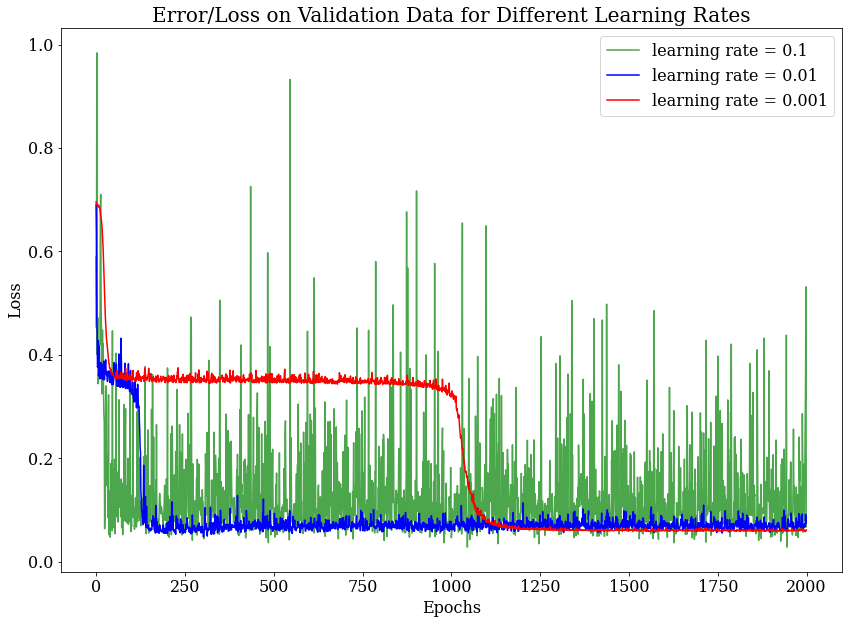

In [8]:
# plot the loss for each learning rate
plt.figure(figsize=(14,10))
plt.plot(val_loss_3, label='learning rate = 0.1', color='green', alpha=0.7)
plt.plot(val_loss_2, label='learning rate = 0.01', color='blue')
plt.plot(val_loss, label='learning rate = 0.001', color='red')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.title('Error/Loss on Validation Data for Different Learning Rates', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.tick_params(labelsize=16)
plt.show()

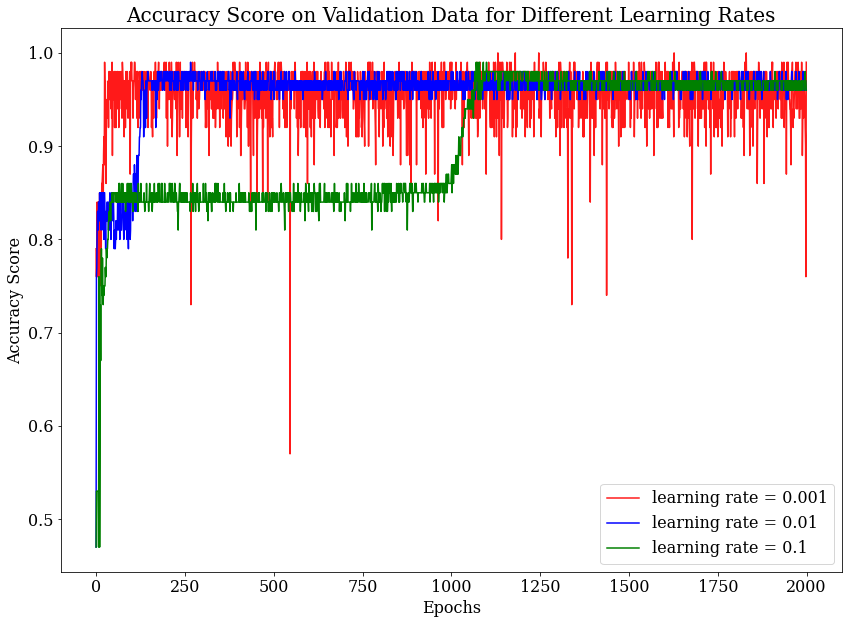

In [13]:
# plot the accuracy for each learning rate
plt.figure(figsize=(14,10))
plt.plot(lr_score_3, label='learning rate = 0.001', color='red', alpha=0.9)
plt.plot(lr_score_2, label='learning rate = 0.01', color='blue')
plt.plot(lr_score, label='learning rate = 0.1', color='green')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy Score', fontsize=16)
plt.title('Accuracy Score on Validation Data for Different Learning Rates', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.tick_params(labelsize=16)
plt.show()

- The plot of the loss for each learning rate and the plot of the accuracy for each learning rate look almost inverse of each other, and therefore show similar information. We can see the learning rate of 0.01 converges to a very low loss with the least amount of epochs, and converges to the highest accuracy score with the least amount of epochs.  The learning rate of 0.1 does converge, but with 4x the amount of epochs as the learning rate of 0.01. Finally, the learning rate of 0.001 does not converge to a small loss or a high accuracy after 2000 epochs, so it is likely this learning rate is too small to ever converge.  Therefore, out of these three options, __the most optimal learning rate is 0.01__.

In two subplots, plot the training data on one subplot, and the validation data on the other subplot. On each plot, also plot the decision boundary from your neural network trained on the training data. 

In [21]:
# learning rate 0.1
best_mlp = MLPClassifier(max_iter=300 , learning_rate_init= 0.01, 
    hidden_layer_sizes=(5,5), solver='sgd', activation='logistic',  
    batch_size=1, tol=1e-10, early_stopping=False, n_iter_no_change = 300,
    random_state=123, warm_start=True).fit(X_train_2, y_train_2)

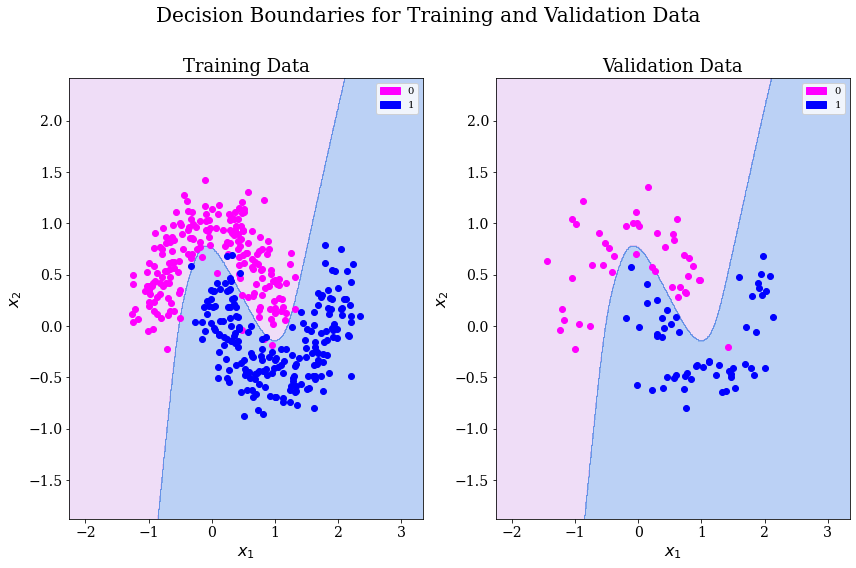

In [26]:
# plot the decision boundaries
h=0.01

fig, ax = plt.subplots(1,2,figsize=(12,8))
fig.suptitle("Decision Boundaries for Training and Validation Data\n", fontsize=20)

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min_0, x_max_0 = X_train_2[:, 0].min() - 1, X_train_2[:, 0].max() + 1
x_min_1, x_max_1 = X_train_2[:, 1].min() - 1, X_train_2[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min_0, x_max_0, h),
                        np.arange(x_min_1, x_max_1, h))

Z = best_mlp.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# creating the background colors
cmap_light = ListedColormap(['#D8ABEB','#558CE6'])
ax[0].contourf(xx, yy, Z, cmap=cmap_light, alpha=0.4)
ax[1].contourf(xx, yy, Z, cmap=cmap_light, alpha=0.4)

# creating the training points
ax[0].scatter(
    X_train_2[y_train_2==0][:,0],
    X_train_2[y_train_2==0][:,1],
    color="magenta", 
    label="Class 0"
)
ax[0].scatter(
    X_train_2[y_train_2==1][:,0],
    X_train_2[y_train_2==1][:,1],
    color="blue",
    label="Class 1"
)

# creating the validation points
ax[1].scatter(
    X_val[y_val==0][:,0],
    X_val[y_val==0][:,1],
    color="magenta", 
    label="Class 0"
)
ax[1].scatter(
    X_val[y_val==1][:,0],
    X_val[y_val==1][:,1],
    color="blue",
    label="Class 1"
)

#creating the legends
label_pink = mpatches.Patch(color= "magenta", label="0", hatch="o")
label_blue = mpatches.Patch(color="blue", label="1", hatch="o")
ax[0].legend(handles=[label_pink,label_blue],loc='best')
ax[1].legend(handles=[label_pink,label_blue],loc='best')

# creating the labels and titles
ax[0].set_title("Training Data", fontsize=18)
ax[0].set_xlabel("$x_1$", fontsize=16)
ax[0].set_ylabel("$x_2$", fontsize=16)
ax[0].tick_params(labelsize=14)
ax[1].set_title("Validation Data", fontsize=18)
ax[1].set_xlabel("$x_1$", fontsize=16)
ax[1].set_ylabel("$x_2$", fontsize=16)
ax[1].tick_params(labelsize=14)

fig.tight_layout()
plt.show()

Report your performance on the test data with an ROC curve and compare against the `scikit-learn` `RandomForestClassifier` trained with the same parameters.

In [29]:
random_forest = RandomForestClassifier(n_estimators=100).fit(X_train, y_train)

In [34]:
# predict probabilities
rf_probs = (random_forest.predict_proba(X_test)[:,1])
nn_probs = (np.array(best_mlp.predict_proba(X_test)[:,1]))
# roc curves
rf_fpr,rf_tpr,threshold = roc_curve(y_test, rf_probs)
nn_fpr,nn_tpr,threshold = roc_curve(y_test, nn_probs)
# auc's
rf_roc_auc = auc(rf_fpr, rf_tpr)
nn_roc_auc = auc(nn_fpr, nn_tpr)

<function matplotlib.pyplot.show(close=None, block=None)>

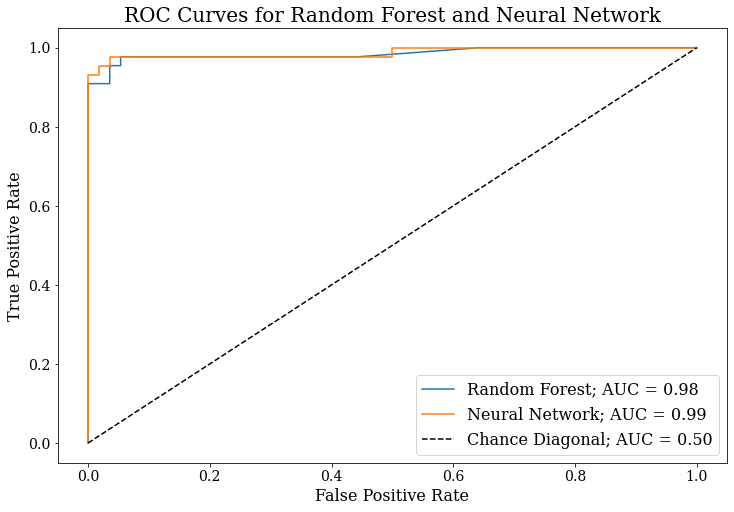

In [119]:
# plot the roc curves
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(rf_fpr,rf_tpr, label="Random Forest; AUC = %0.2f" % rf_roc_auc)
plt.plot(nn_fpr,nn_tpr, label="Neural Network; AUC = %0.2f" %  nn_roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label="Chance Diagonal; AUC = %0.2f" % 0.5)
plt.xlabel("False Positive Rate", fontsize=16)
plt.ylabel("True Positive Rate", fontsize=16)
plt.title("ROC Curves for Random Forest and Neural Network", fontsize=20)
plt.tick_params(labelsize=14)
plt.legend(loc='lower right', fontsize=16)
plt.show

**(c)** Suggest two ways in which you neural network implementation could be improved: are there any options we discussed in class that were not included in your implementation that could improve performance?

**ANSWER**

- There is a high potential of gradient vanishing when too many layers will be added here. So that should be limited and the neural network should not be so generalized
- Dropout layers could be added